In [1]:
import os
import pandas as pd
import mlflow
import mlflow.tensorflow
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [2]:
sample_csv_path = "/Users/maurice/Documents/certification/dermdetect/csv/sample_dataset.csv"
sampled_image_dir = "/Users/maurice/Documents/data_nogit/Dermdetect/SAMPLE_20"

In [3]:
df_sample = pd.read_csv(sample_csv_path)
df_sample

,image_id,target
0,isic_0014666_1.jpg,malignant
1,isic_4974820_0.jpg,benign
2,isic_0071045_4.jpg,malignant
3,isic_5189439_3.jpg,malignant
4,isic_0817140_0.jpg,benign
...,...,...
14515,isic_0033552_0.jpg,benign
14516,isic_7490806_0.jpg,malignant
14517,isic_7072802_0.jpg,benign
14518,isic_0025505_0.jpg,benign


In [4]:
img_generator = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.3
)

In [5]:
# Générateur pour l'ensemble d'entraînement
train_generator = img_generator.flow_from_dataframe(
    dataframe=df_sample,
    directory=sampled_image_dir,
    x_col="image_id",
    y_col="target",
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary",
    #shuffle=True,
    subset="training",
    seed=42
)

# Générateur pour l'ensemble de validation
val_generator = img_generator.flow_from_dataframe(
    dataframe=df_sample,
    directory=sampled_image_dir,
    x_col="image_id",
    y_col="target",
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary",
    #shuffle=True,
    subset="validation",
    seed=42
)

Found 10164 validated image filenames belonging to 2 classes.
Found 4356 validated image filenames belonging to 2 classes.


In [6]:
base_model  = ResNet50(
                        weights='imagenet',
                        include_top=False,
                        input_shape=(128, 128, 3)
                        )

base_model.trainable = False  # Freeze the base model

In [7]:
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

In [8]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy',  
              metrics=['accuracy', 
                       Precision(name="precision"), 
                       Recall(name="recall"), 
                       tf.keras.metrics.AUC(name="auc")]
              )

In [9]:
model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    verbose=1
    )

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


318/318 ━━━━━━━━━━━━━━━━━━━━ 71s 218ms/step - accuracy: 0.5601 - auc: 0.5893 - loss: 0.7206 - precision: 0.5484 - recall: 0.5177 - val_accuracy: 0.6283 - val_auc: 0.8200 - val_loss: 0.6159 - val_precision: 0.8787 - val_recall: 0.2989
Epoch 2/5
318/318 ━━━━━━━━━━━━━━━━━━━━ 71s 224ms/step - accuracy: 0.6854 - auc: 0.7451 - loss: 0.5979 - precision: 0.6983 - recall: 0.6409 - val_accuracy: 0.7165 - val_auc: 0.8344 - val_loss: 0.5799 - val_precision: 0.6478 - val_recall: 0.9505
Epoch 3/5
318/318 ━━━━━━━━━━━━━━━━━━━━ 74s 234ms/step - accuracy: 0.6871 - auc: 0.7573 - loss: 0.5857 - precision: 0.6880 - recall: 0.6378 - val_accuracy: 0.6882 - val_auc: 0.8432 - val_loss: 0.5553 - val_precision: 0.8575 - val_recall: 0.4525
Epoch 4/5
318/318 ━━━━━━━━━━━━━━━━━━━━ 77s 243ms/step - accuracy: 0.7332 - auc: 0.8130 - loss: 0.5355 - precision: 0.7515 - recall: 0.6675 - val_accuracy: 0.7247 - val_auc: 0.8524 - val_loss: 0.5606 - val_precision: 0.6544 - val_recall: 0.9541
Epoch 5/5
318/318 ━━━━━━━━━━━━━━━━

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Obtenir les vraies étiquettes du set de validation
y_true = val_generator.classes  # Contient les vraies classes (0 ou 1)

# Prédire les probabilités des images du set de validation
y_pred_proba = model.predict(val_generator)

# Convertir les probabilités en classes binaires (seuil à 0.5)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calcul des scores
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Affichage des résultats
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 25s 175ms/step
Accuracy : 0.5083
Precision : 0.5049
Recall : 0.9207
F1-score : 0.6522


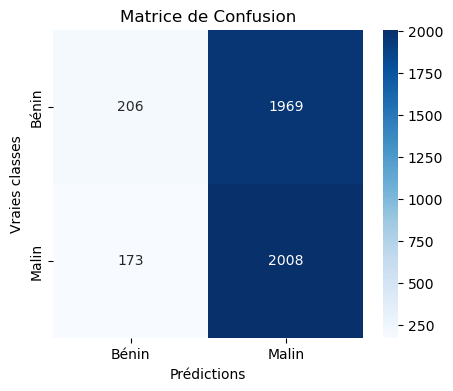

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)

# Afficher sous forme de heatmap
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Bénin", "Malin"], yticklabels=["Bénin", "Malin"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

